check read.me file in github

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import pandas as pd
import mdtraj as md

In [2]:
pdb = '/home/exx/Downloads/nmrgnn/ligand.pdb'
trajectory = '/home/exx/Downloads/nmrgnn/lig_full_traj.dcd'
outdir = '/home/exx/Downloads/nmrgnn/output/'
if not os.path.exists('outdir/'):
     os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)   

outdir: /home/exx/Downloads/nmrgnn/output/
pdb: /home/exx/Downloads/nmrgnn/ligand.pdb
trjaectory: /home/exx/Downloads/nmrgnn/lig_full_traj.dcd


In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

In [4]:
trj

<mdtraj.Trajectory with 55157 frames, 61 atoms, 1 residues, and unitcells at 0x7fb6245ae890>

In [5]:
atoms, bonds = trj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C,C,58,LIG,0,
1,2,C1,C,58,LIG,0,
2,3,C2,C,58,LIG,0,
3,4,C3,C,58,LIG,0,
4,5,C4,C,58,LIG,0,
...,...,...,...,...,...,...,...
56,57,H23,H,58,LIG,0,
57,58,H24,H,58,LIG,0,
58,59,H25,H,58,LIG,0,
59,60,H26,H,58,LIG,0,


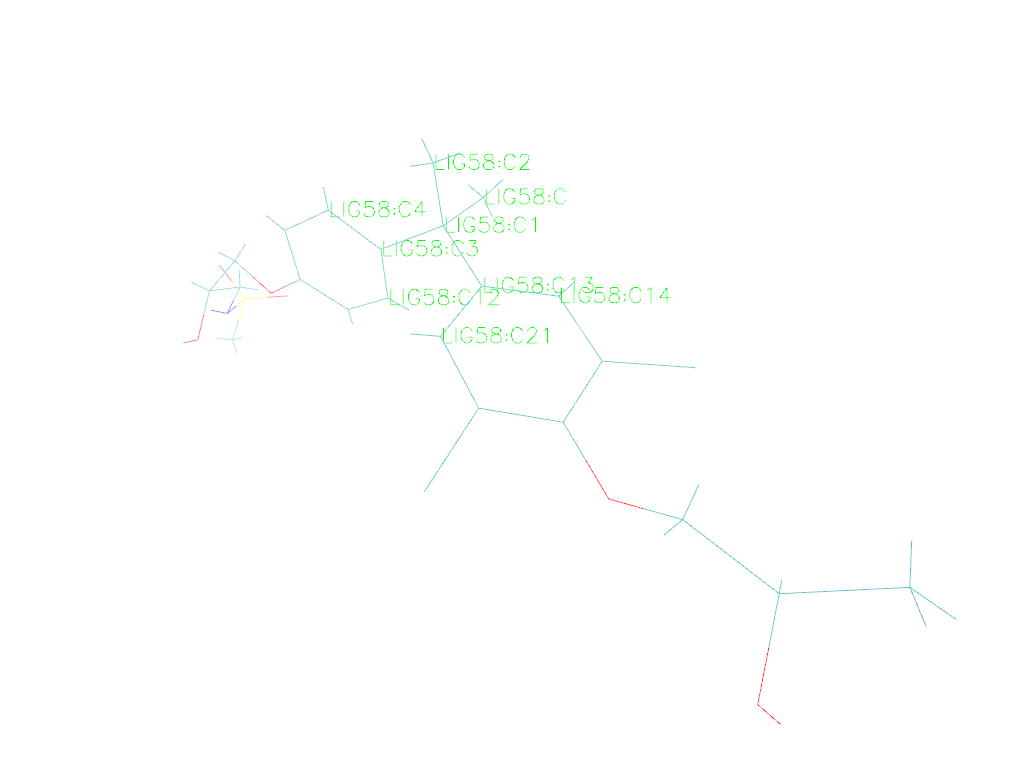

In [66]:
from IPython.display import Image
Image(filename= "/home/exx/Downloads/nmrgnn/ligand1.png") 

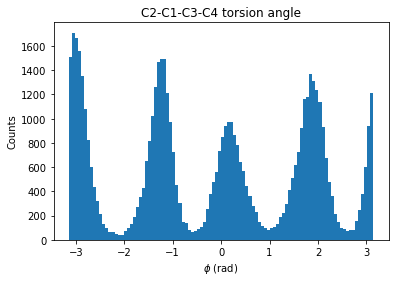

In [21]:
phi_indices = [2, 1, 3, 4] # atoms to define the torsion angle
phi = md.compute_dihedrals(trj, [phi_indices])

phicounts, binedges, otherstuff = plt.hist(phi, bins=100) # create a histogram with 90 bins
plt.title('C2-C1-C3-C4 torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

Text(0, 0.5, 'phi radians')

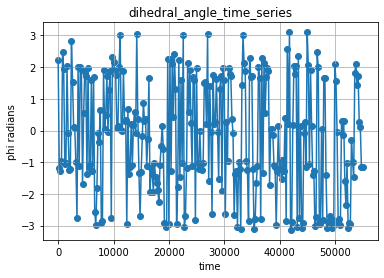

In [64]:
time_series = np.linspace(0, 55157, 55157)
plt.plot(time_series[::200], phi[::200])
plt.scatter(time_series[::200], phi[::200])
plt.grid()
plt.title("dihedral_angle_time_series")
plt.xlabel("time")
plt.ylabel("phi radians")

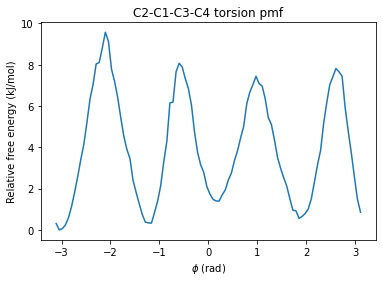

In [22]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C2-C1-C3-C4 torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

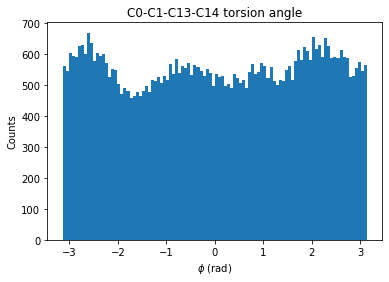

In [23]:
phi_indices_1 = [0, 1, 13, 14] # atoms to define the torsion angle
phi_1 = md.compute_dihedrals(trj, [phi_indices_1])
phicounts, binedges, otherstuff = plt.hist(phi_1, bins=100) # create a histogram with 90 bins
plt.title('C0-C1-C13-C14 torsion angle')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Counts')
plt.show()

Text(0, 0.5, 'phi radians')

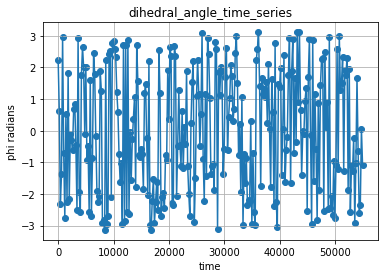

In [67]:
time_series = np.linspace(0, 55157, 55157)
plt.plot(time_series[::200], phi_1[::200])
plt.scatter(time_series[::200], phi_1[::200])
plt.grid()
plt.title("dihedral_angle_time_series")
plt.xlabel("time")
plt.ylabel("phi radians")

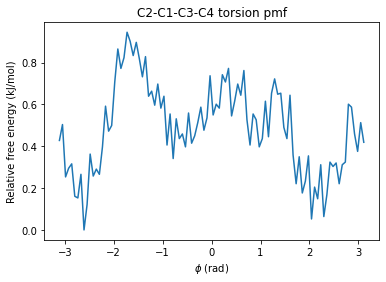

In [24]:
kB = 8.31446/1000 # Boltzmann constant in kJ/mol
Temp = 298.15 # simulation temperature
phicounts[phicounts==0] = 0.1 # get rid of any bins with 0 counts/infinite energy
pmf = -kB*Temp*np.log(phicounts) # W(x) = -kT*ln[p(x)] = -kT*ln[n(x)] + C
pmf = pmf - np.min(pmf) # subtract off minimum value so that energies start from 0

bincenters = (binedges[1:] + binedges[:-1])/2 # compute centers of histogram bins

plt.plot(bincenters, pmf)
plt.title('C2-C1-C3-C4 torsion pmf')
plt.xlabel(r'$\phi$ (rad)')
plt.ylabel('Relative free energy (kJ/mol)')
plt.show()

In [31]:
data = pd.read_csv('/home/exx/Downloads/nmrgnn/ligand.csv', header=None)

/home/exx/miniconda3/envs/New_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3186: DtypeWarning: Columns (0,2,4,5,6,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [32]:
data_h= pd.read_csv('/home/exx/Downloads/nmrgnn/ligand.csv')
data_h

,index,residues,resids,names,peaks,confident,time,frame
0,0,LIG,58,C,37.15,True,0.000000,0
1,1,LIG,58,C1,57.26,True,0.000000,0
2,2,LIG,58,C2,28.36,True,0.000000,0
3,3,LIG,58,C3,136.30,True,0.000000,0
4,4,LIG,58,C4,127.24,True,0.000000,0
...,...,...,...,...,...,...,...,...
3364572,56,LIG,58,H23,4.15,True,2696.478111,55156
3364573,57,LIG,58,H24,5.73,True,2696.478111,55156
3364574,58,LIG,58,H25,4.91,True,2696.478111,55156
3364575,59,LIG,58,H26,3.91,True,2696.478111,55156


In [33]:
A = data[(data== 'C1').any(axis=1)]
print(A)

         0    1   2   3      4     5                    6      7
2        1  LIG  58  C1  57.26  True                  0.0      0
63       1  LIG  58  C1  57.57  True           0.04888821      1
124      1  LIG  58  C1  57.38  True           0.09777642      2
185      1  LIG  58  C1  56.34  True  0.14666463000000002      3
246      1  LIG  58  C1  62.12  True           0.19555284      4
...     ..  ...  ..  ..    ...   ...                  ...    ...
3364274  1  LIG  58  C1  61.32  True          2696.282558  55152
3364335  1  LIG  58  C1  55.14  True          2696.331446  55153
3364396  1  LIG  58  C1  57.54  True          2696.380334  55154
3364457  1  LIG  58  C1  63.31  True          2696.429223  55155
3364518  1  LIG  58  C1  53.29  True          2696.478111  55156

[55157 rows x 8 columns]


In [34]:
trj

<mdtraj.Trajectory with 55157 frames, 61 atoms, 1 residues, and unitcells at 0x7fb6245ae890>

In [35]:
A[6].shape

(55157,)

In [49]:
time_series = np.linspace(0, 55157, 55157)

In [56]:
trunc = A[4][::200].astype(float)
trunc

2          57.26
12202      55.54
24402      59.48
36602      56.95
48802      55.78
           ...  
3306202    60.26
3318402    55.90
3330602    52.95
3342802    57.31
3355002    58.87
Name: 4, Length: 276, dtype: float64

In [57]:
trunc_time = time_series[::200]

In [50]:
chem_shifts_C= A[4].astype(float)
chem_shifts_C

2          57.26
63         57.57
124        57.38
185        56.34
246        62.12
           ...  
3364274    61.32
3364335    55.14
3364396    57.54
3364457    63.31
3364518    53.29
Name: 4, Length: 55157, dtype: float64

Text(0.5, 0, 'time')

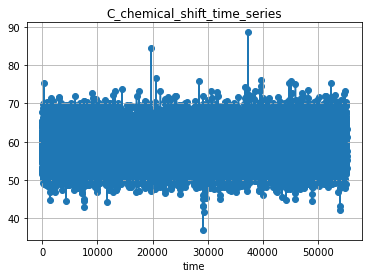

In [51]:
plt.plot(time_series, chem_shifts_C)
plt.scatter(time_series, chem_shifts_C)
plt.grid()
plt.title("C_chemical_shift_time_series")
plt.xlabel("time")

Text(0.5, 0, 'time')

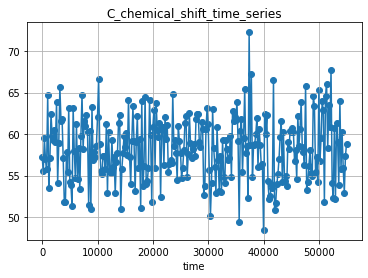

In [58]:
plt.plot(trunc_time, trunc)
plt.scatter(trunc_time, trunc)
plt.grid()
plt.title("C_chemical_shift_time_series")
plt.xlabel("time")

In [103]:
phi

array([[ 2.2108357],
       [ 1.7202939],
       [-2.8657415],
       ...,
       [-3.1204858],
       [-1.1164439],
       [ 2.9735563]], dtype=float32)

In [224]:
basin_1 = np.where(phi<-2.5)
basin_2 = np.where((phi>-2)&(phi<-0.5))
basin_3 = np.where((phi>-0.5)&(phi<1))
basin_4 = np.where((phi>1)&(phi<2.5))
basin_5 = np.where((phi>2.5))

In [225]:
basin_4[0].shape

(14517,)

In [226]:
os.getcwd()

'/home/exx/Downloads/nmrgnn'

In [227]:
cs = A[4].to_numpy()
basin1_cs = cs[basin_1[0]].astype(np.float32)
basin2_cs = cs[basin_2[0]].astype(np.float32)
basin3_cs = cs[basin_3[0]].astype(np.float32)
basin4_cs = cs[basin_4[0]].astype(np.float32)
basin5_cs = cs[basin_5[0]].astype(np.float32)

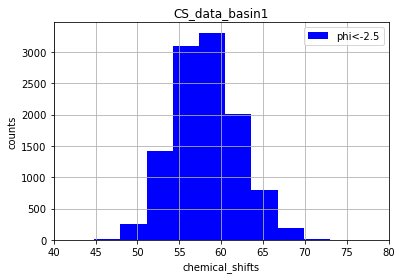

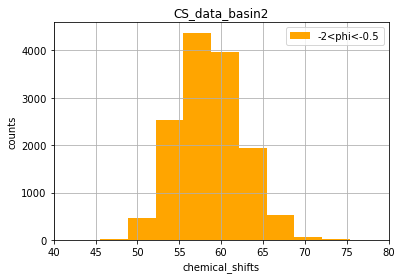

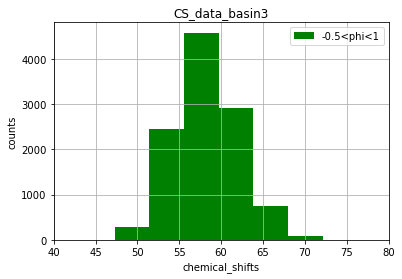

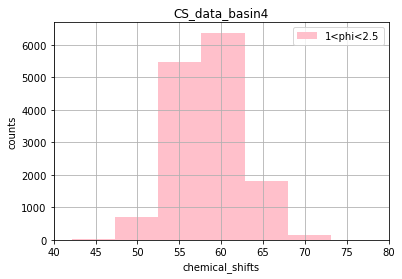

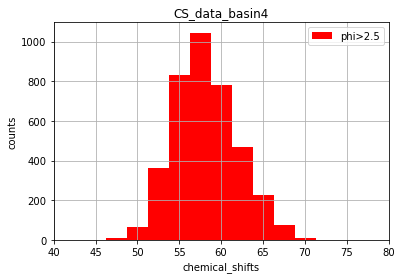

In [243]:
plt.hist(basin1_cs, bins=10, label="phi<-2.5", color='b')
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin1")
plt.savefig("CS-basin1.png")
plt.show()



plt.hist(basin2_cs, bins=10, label="-2<phi<-0.5", color='orange')
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin2")
plt.savefig("CS-basin2.png")
plt.show()



plt.hist(basin3_cs, bins=10, label="-0.5<phi<1", color="g")
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin3")
plt.savefig("CS-basin3.png")
plt.show()

plt.hist(basin4_cs, bins=10, label="1<phi<2.5", color="pink")
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin4")
plt.savefig("CS-basin4.png")
plt.show()

plt.hist(basin5_cs, bins=10, label="phi>2.5", color="r")
plt.grid()
plt.xlabel("chemical_shifts")
plt.ylabel("counts")
plt.legend()
plt.xlim(40,80)
plt.title("CS_data_basin4")
plt.savefig("CS-basin5.png")
plt.show()


In [234]:
data_list = [basin1_cs, basin2_cs, basin3_cs, basin4_cs, basin5_cs]
labels = ["basin{}".format(i) for i in range(1,6)]

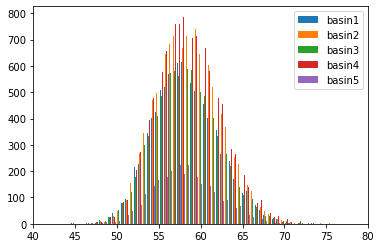

In [245]:
plt.hist(data_list, label=labels, bins=100)
plt.xlim(40,80)
plt.legend()
plt.savefig("cs_data_histogram.png")

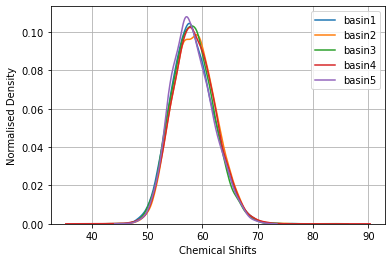

In [275]:
for data,label in zip(data_list,labels):
    sns.kdeplot(data,label=label)
plt.legend()
plt.grid()
plt.xlabel("Chemical Shifts")
plt.ylabel("Normalised Density")
plt.savefig("densityplotbasins.png")

In [251]:
data_list = [basin1_cs, basin2_cs, basin3_cs, basin4_cs, basin5_cs]
labels = ["basin{}".format(i) for i in range(1,6)]

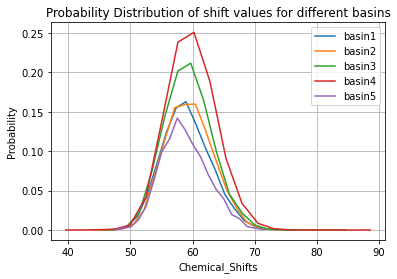

In [273]:
count1, edges1 = np.histogram(basin1_cs, bins = 20)
density_angle1 = count1 / np.sum(count1)


count2, edges2 = np.histogram(basin2_cs, bins=20)
density_angle2 = count2 / np.sum(count2)

count3, edges3 = np.histogram(basin3_cs, bins=20)
density_angle3 = count3 / np.sum(count3)

count4, edges4 = np.histogram(basin4_cs, bins=20)
density_angle4 = count4 / np.sum(count4)

count5, edges5 = np.histogram(basin5_cs, bins=20)
density_angle5 = count5 / np.sum(count5)



plt.plot(edges1[1:], density_angle1, label="basin1" )
plt.plot(edges2[1:], density_angle2, label="basin2" )
plt.plot(edges3[1:], density_angle3, label="basin3" )
plt.plot(edges4[1:], density_angle4, label="basin4" )
plt.plot(edges5[1:], density_angle5, label="basin5" )

plt.xlabel("Chemical_Shifts")
plt.ylabel("Probability")
plt.title("Probability Distribution of shift values for different basins")
plt.grid()
plt.legend()
plt.show()   